# 9. Prädiktion der Arbeitslosenzahlen mit FFT und Poly-Regr.

In [16]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.fft import fft, fftfreq
import scipy as sp

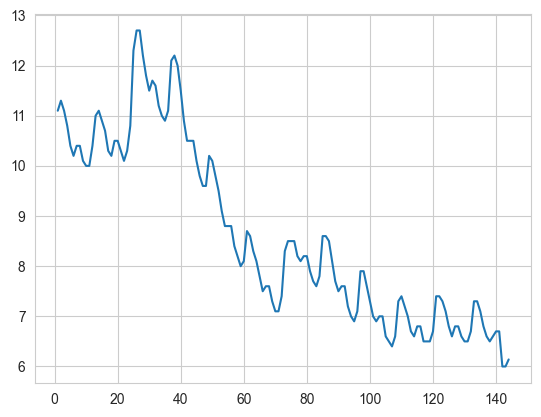

In [17]:
# Import der Daten
data = pd.read_csv('Arbeitslose.csv', sep=';')

plt.plot(data['Monate'],data['Arbeitslose'])

In [18]:
start=0
# Wichtig,1! Wir verwenden nur die letzten 69 Werte der Arbeitslosenzahlen, da diese sich durch eine homogene Entwicklung darstellen und nicht durch stufige Entwicklungen, welche durch subjektive Gesetzgebungsverfahren beeinflusst sind (dann wäre die Regression auch sinnlos)
# Wichtig,2! Wir müssen die Zeit für dieses Intervall aber auch bei t = 0 beginnen lassen, weil sonst die spätere Zusammensetzung des prädizierten Signals aus den Elementaroszillationen nicht funktioniert
t = data['Monate']
#t = data.iloc[:,0].values[0:69]
arbeitslose = data['Arbeitslose']
#arbeitslose = data.iloc[:,1].values[75:]

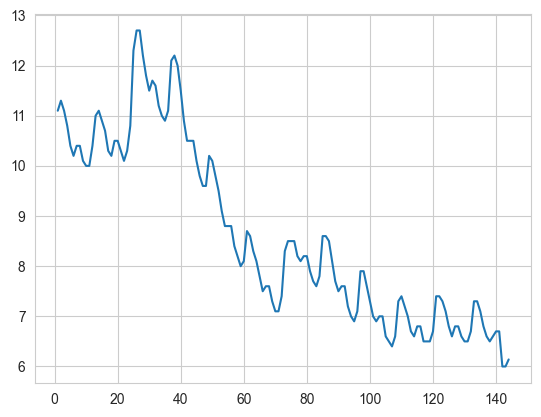

In [19]:
# Ausagbe im Diagramm
plt.plot(t,arbeitslose)

In [28]:
# FFT
N = len(arbeitslose)
# Sample Spacing
T = 1
arbeitslose = np.array(arbeitslose)
yf = fft(arbeitslose)
yf[np.abs(yf)<20] = 0
f = np.linspace(0,0.5*1/T,int(N/2))

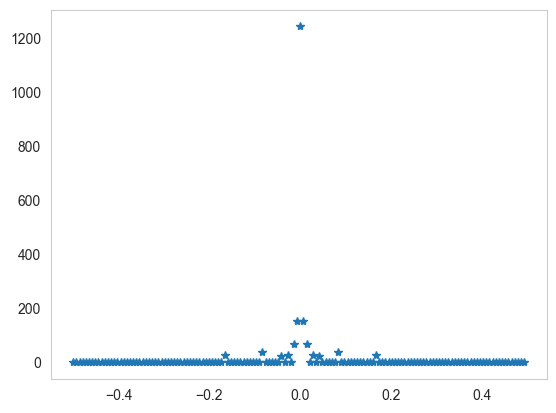

In [29]:
# Frequency Plot
SAMPLE_RATE = 1
DURATION = 144
f = fftfreq(N, 1/SAMPLE_RATE)
plt.plot(f, np.abs(yf),'*')
plt.grid()

In [30]:
# Inverse FFT
a_inverse = sp.ifft(yf)


C:\Users\TorstenSchmidt\AppData\Local\Temp\ipykernel_27940\4047675464.py:2: DeprecationWarning: scipy.ifft is deprecated and will be removed in SciPy 2.0.0, use scipy.fft.ifft instead
  a_inverse = sp.ifft(yf)


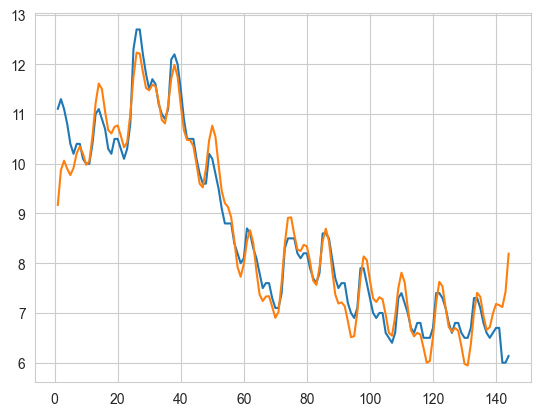

In [31]:
plt.plot(t,np.abs(arbeitslose),t,np.abs(a_inverse))

### Forecasting the time-series with fourier and polynomial fit

### A. Polynomial Regression

In [59]:
# working with data as pd dataset
# data['moving_avg'] = data[1].rolling(window=10).mean()
# mov_avg = np.array(data['moving_avg'].dropna())
# t1 = np.array(data['moving_avg'].index)[np.isnan(data['moving_avg'])==False]
# plt.plot(t, data[1], t1, mov_avg)
#y_full =np.array(data[1])[0:127]

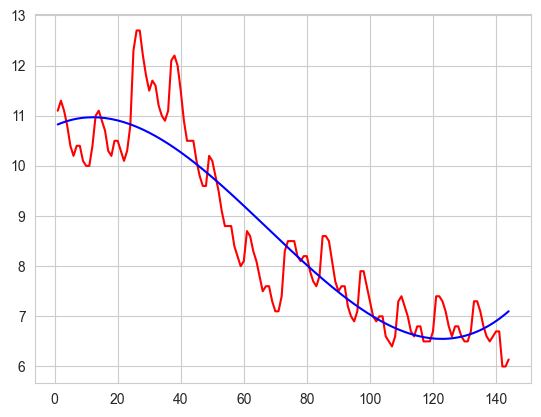

In [41]:
# Fitting Polynomial Regression to the moving average data
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
t = np.array(t)
arbeitslose = np.array(arbeitslose)

X = t.reshape(-1,1)

y = arbeitslose.reshape(-1,1)
lin_reg.fit(X, y)

from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=3)

X_poly = poly_reg.fit_transform(X)

pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)
#
# Visualizing the Polymonial Regression results
y_poly = pol_reg.predict(poly_reg.fit_transform(X))
y_poly = y_poly.ravel()
plt.plot(X, y, color='red')
plt.plot(X, y_poly, color='blue')


### B. Extraktion des Residuums y_diff = y - y_poly

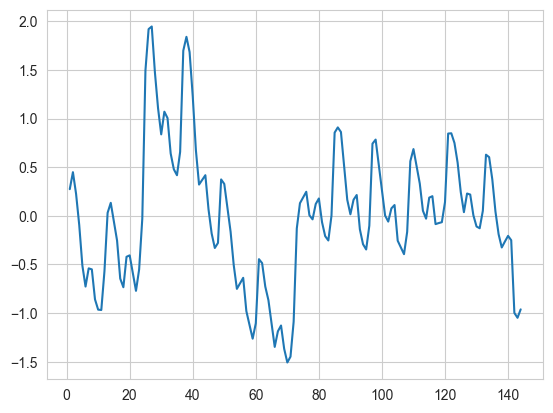

In [42]:
#Calculating the data - poly_data values
y_diff = y - pol_reg.predict(poly_reg.fit_transform(X))
plt.plot(t, y_diff)
SAMPLE_RATE = 1/(t[2]-t[1])
DURATION = y.size
y_diff = y_diff.flatten()

### C. Fourier-Trafo des Residuums

In [50]:
from scipy.fft import fft, fftfreq
N = int(SAMPLE_RATE * DURATION)
yf = fft(y_diff)
f = fftfreq(N, 1/SAMPLE_RATE)
yf[np.abs(yf)<20] = 0
yf[np.abs(yf)>40] = 0
import plotly.express as px
fig = px.scatter(x=1/f, y=np.abs(yf))
fig.show()

C:\Users\TorstenSchmidt\AppData\Local\Temp\ipykernel_27940\736645406.py:7: RuntimeWarning:

divide by zero encountered in divide



### D. Berechnung des prädizierten Residuums für einen längeren Zeitraum (in die Zukunft) durch Zusammensetzung der Elementaroszillationen A * cos(2 * Pi * f * t + Phi)

In [51]:
t_ext = np.arange(0, 155, 1/SAMPLE_RATE)
residuum_predicted = np.zeros(t_ext.size)
for i in range(f.size):
    ampli = np.abs(yf[i]) / N  # amplitude
    phase = np.angle(yf[i])  # phase
    residuum_predicted += ampli * np.cos(2 * np.pi * f[i] * t_ext + phase) # Elementaroszillationen



### E. Berechnung des polynomialen Anteils auch für t_ext, Zusammensetzung zu y_predict = y_poly + residuum_predicted und Darstellung im Diagramm

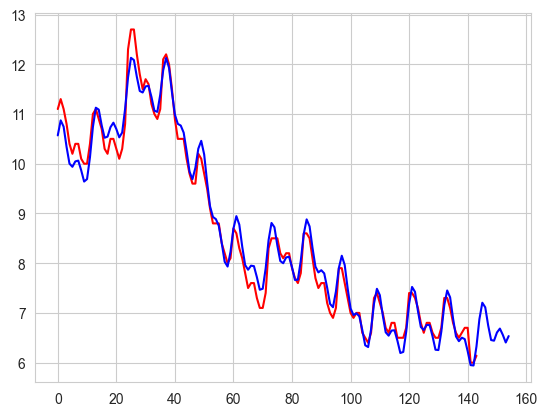

In [52]:
# Adding Polynomial Regression
X_ext = t_ext.reshape(-1,1)
y_ext = y_diff
X = t.reshape(-1,1)
y = y.reshape(-1,1)

# Visualizing the Prediction results
y_poly = pol_reg.predict(poly_reg.fit_transform(X_ext))
y_poly = y_poly.ravel()
y_predict = residuum_predicted + y_poly
plt.plot(t-1, y, color='red')
plt.plot(X_ext, y_predict, color='blue')